In [1]:
#Import the libraries
import numpy as np
import pandas as pd

import pickle

import warnings
warnings.filterwarnings("ignore")

In [2]:
train_data = pickle.load(open('clean_dataset_2022/train_set.bin', 'rb'))

test_data = pickle.load(open('clean_dataset_2022/test_set.bin', 'rb'))

## SARIMAX

In [3]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

### Resample

In [4]:
province = ['BKK','CNX','KKC','RAY','SARA','SURAT']

In [5]:
for p in province:
    train_data[p] = train_data[p].resample('6H').mean()

    tmp_df = test_data[p].copy()
    tmp_df['PM25'] = test_data[p]['PM25'].asfreq(freq='6H')
    test_data[p] = test_data[p].resample('6H').mean()
    test_data[p]['PM25'] = tmp_df['PM25']

### Split 70% 30%

In [6]:
train_set = {} ; valid_set = {} ; test_set = test_data

ratio = 0.7

for p in province:
    train_size, valid_size = int(ratio*train_data[p].shape[0]), int((1-ratio)*train_data[p].shape[0])
    train_set[p], valid_set[p] = train_data[p].iloc[:train_size], train_data[p].iloc[train_size: ]

### Training 6 provinces with *minimal_SARIMAX*

In [7]:
from importlib import reload

In [52]:
from custom_function import minimalSARIMAX

reload(minimalSARIMAX)

from custom_function.minimalSARIMAX import MinimalSARIMAX

##### Tuning Parameters

In [85]:
order = [(2, 0, 0), (2, 1, 0), (2, 1, 0), (2, 1, 0), (1, 0, 1), (2, 0, 0)]
seasonal_order = [(1, 0, 0, 1461), (0, 1, 1, 1461), (0, 1, 1, 1461), (0, 0, 0, 1461), (0, 0, 0, 1461), (0, 1, 0, 1461)]

exog_order = {}
exog_order['Temp'] = [(1, 1, 0), (1, 1, 0), (1, 1, 0), (1, 0, 0), (1, 1, 0), (1, 1, 0)]
exog_order['WindSpeed'] = [(1, 1, 0), (1, 1, 0), (1, 1, 0), (1, 1, 0), (1, 0, 0), (1, 1, 0)]
exog_order['WindDir'] = [(1, 1, 0), (1, 0, 0), (2, 0, 0), (1, 1, 0), (1, 0, 0), (1, 0, 1)]

exog_seasonal_order = {}
exog_seasonal_order['Temp'] = [(0, 1, 1, 1461), (0, 1, 1, 1461), (0, 1, 1, 1461), (0, 0, 1, 1461), (0, 1, 0, 1461), (0, 1, 1, 1461)]
exog_seasonal_order['WindSpeed'] = [(0, 1, 1, 1461), (0, 1, 1, 1461), (0, 1, 1, 1461), (0, 1, 1, 1461), (0, 0, 0, 1461), (0, 1, 1, 1461)]
exog_seasonal_order['WindDir'] = [(1, 1, 0, 1461), (0, 1, 0, 1461), (1, 0, 0, 1461), (1, 1, 0, 1461), (0, 1, 1, 1461), (0, 1, 1, 1461)]

exog_columns = ['Temp', 'WindSpeed', 'WindDir']

In [86]:
model = {}
model_exog = {}

for i, p in enumerate(province):
    model[p] = MinimalSARIMAX(train_data[p][['PM25']],
                order[i],
                seasonal_order[i],
                exog=train_data[p][exog_columns])
    
    model_exog[p] = {}    
    for exog in exog_columns:
        model_exog[p][exog] = MinimalSARIMAX(train_data[p][[exog]],
                                            exog_order[exog][i],
                                            exog_seasonal_order[exog][i])

In [87]:
for p in province:
    model[p].fit(lr=1e-5, lr_decay=0.999 ,verbose=0)

In [88]:
for p in province:
    for exog in exog_columns:
        if exog == 'WindDir':
            model_exog[p][exog].fit(lr=5e-7, lr_decay=0.999, verbose=0)
        else:
            model_exog[p][exog].fit(lr=1e-5, lr_decay=0.999, verbose=0)

In [97]:
Result = model['CNX'].predict_step(valid_set['CNX'][['PM25']],
                                    test_set['CNX'][['PM25']], 
                                    val_X_exog=valid_set['CNX'][exog_columns],
                                    y_exog=test_set['CNX'][exog_columns], 
                                    model_exog=model_exog['CNX'],
                                    lr=np.array([1e-7, 1e-6, 1e-7, 5e-9]), lr_decay=0.9998975,
                                    step=12, learn=False)

val_pred_sav, y_pred_sav, Error_save = Result

100%|██████████| 2779/2779 [07:28<00:00,  6.19it/s]


In [98]:
model['CNX'].params

{'p': array([0.2895623 , 0.19992678]),
 'pX': array([ 0.04595378,  0.03923863, -0.06612614]),
 'd': array([0.02030352]),
 'q': array([0.]),
 'P': array([0.]),
 'D': array([0.17758979]),
 'Q': array([0.01202504]),
 'c': 0.07647802212371704}

In [76]:
with open('model_save/model_cnx.model',"wb") as g:
    pickle.dump(model['CNX'], g)

In [99]:
bb = y_pred_sav.sort_values(by=['Time'])
X = pd.concat([val_pred_sav,y_pred_sav]).sort_values(by=['Time'])
X_time = X.drop_duplicates(subset=['Time'])

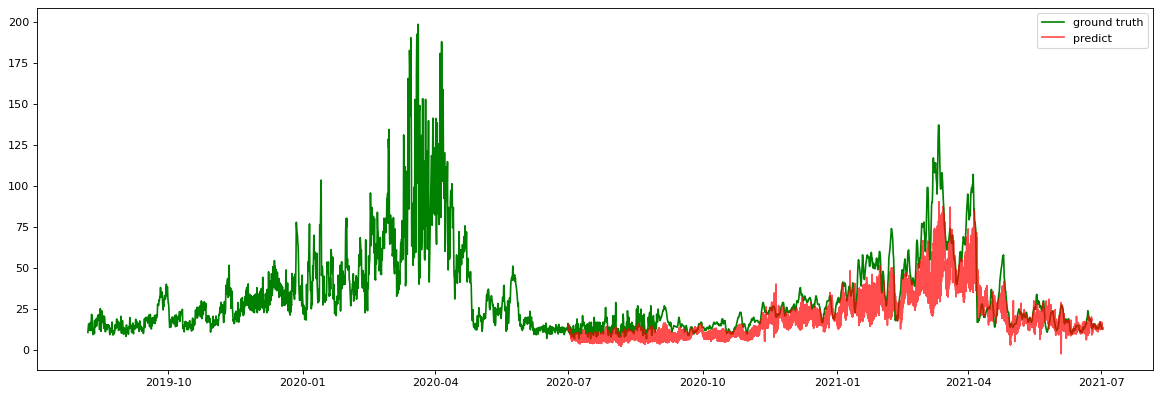

In [100]:
plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(X_time['Time'],X_time['Actual'], color='g',label='ground truth')
plt.plot(bb['Time'],bb['Predict'], alpha=.7, color='r',label='predict')
plt.legend(loc="upper right")

In [34]:
val_pred_sav.to_csv('cnx_train_pred.csv')
y_pred_sav.to_csv('cnx_val_pred.csv')

In [35]:
pa_dict = {}

for p in province:
    pa_dict[p] = pd.read_csv('answer_dataset/pred_and_actual/y_pred_sav_'+p+'.csv', names=['Time','Predict','Actual'], skiprows=1)

In [36]:
pa_dict['BKK'] = pd.read_csv('answer_dataset/pred_and_actual/y_pred_sav_BKK2.csv', names=['Time','Predict','Actual'], skiprows=1)

In [37]:
sb_bkk = pd.read_csv('answer_dataset/submission_answer/y_pred_BKK.csv', names=['Predict'], skiprows=1)[12:]
sb_bkk['Time'] = pa_dict[p]['Time']

sb_cnx = pd.read_csv('answer_dataset/submission_answer/y_pred_CNX.csv', names=['Predict'], skiprows=1)[12:]
sb_cnx['Time'] = pa_dict[p]['Time']

sb_kkc = pd.read_csv('answer_dataset/submission_answer/y_pred_KKC.csv', names=['Predict'], skiprows=1)[12:]
sb_kkc['Time'] = pa_dict[p]['Time']

sb_ray = pd.read_csv('answer_dataset/submission_answer/y_pred_RAY.csv', names=['Predict'], skiprows=1)[12:]
sb_ray['Time'] = pa_dict[p]['Time']

sb_sara = pd.read_csv('answer_dataset/submission_answer/y_pred_SARA.csv', names=['Predict'], skiprows=1)[12:]
sb_sara['Time'] = pa_dict[p]['Time']

sb_surat = pd.read_csv('answer_dataset/submission_answer/y_pred_SURAT.csv', names=['Predict'], skiprows=1)[12:]
sb_surat['Time'] = pa_dict[p]['Time']

In [38]:
ms_date = {}
ms_date_bkk = pd.read_csv('datasci_dataset_2022/_missing_date/missing_test_date_bkk.csv',names=['Time'],skiprows=1)
ms_date_cnx = pd.read_csv('datasci_dataset_2022/_missing_date/missing_test_date_chiangmai.csv',names=['Time'],skiprows=1)
ms_date_kkc = pd.read_csv('datasci_dataset_2022/_missing_date/missing_test_date_khonkaen.csv',names=['Time'],skiprows=1)
ms_date_ray = pd.read_csv('datasci_dataset_2022/_missing_date/missing_test_date_rayong.csv',names=['Time'],skiprows=1)
ms_date_sara = pd.read_csv('datasci_dataset_2022/_missing_date/missing_test_date_saraburi.csv',names=['Time'],skiprows=1)
ms_date_surat = pd.read_csv('datasci_dataset_2022/_missing_date/missing_test_date_surat.csv',names=['Time'],skiprows=1)

In [39]:
duplicates = pd.merge(sb_bkk,ms_date_bkk,how='inner',on=['Time'])['Time']
sb_bkk = sb_bkk[ ~sb_bkk['Time'].isin(duplicates) ]

duplicates = pd.merge(sb_cnx,ms_date_cnx,how='inner',on=['Time'])['Time']
sb_cnx = sb_cnx[ ~sb_cnx['Time'].isin(duplicates) ]

duplicates = pd.merge(sb_kkc,ms_date_kkc,how='inner',on=['Time'])['Time']
sb_kkc = sb_kkc[ ~sb_kkc['Time'].isin(duplicates) ]

duplicates = pd.merge(sb_ray,ms_date_ray,how='inner',on=['Time'])['Time']
sb_ray = sb_ray[ ~sb_ray['Time'].isin(duplicates) ]

duplicates = pd.merge(sb_sara,ms_date_sara,how='inner',on=['Time'])['Time']
sb_sara = sb_sara[ ~sb_sara['Time'].isin(duplicates) ]

duplicates = pd.merge(sb_surat,ms_date_surat,how='inner',on=['Time'])['Time']
sb_surat = sb_surat[ ~sb_surat['Time'].isin(duplicates) ]

In [40]:
# sb_bkk.to_csv('answer_dataset/submission_answer_nomissing/y_pred_bkk.csv')

In [41]:
sb_bkk.head()

,Predict,Time
12,5.666645,2020-07-01 06:00:00
13,8.309232,2020-07-01 12:00:00
14,5.918406,2020-07-01 18:00:00
15,7.008579,2020-07-02 00:00:00
16,5.662199,2020-07-02 06:00:00


In [42]:
ls_sb = [sb_bkk, sb_cnx, sb_ray, sb_sara, sb_kkc, sb_surat]

finalll = pd.concat(ls_sb)
finalll['Predicted'] = finalll['Predict']
finalll = finalll[['Predicted']].reset_index()
finalll

,index,Predicted
0,12,5.666645
1,13,8.309232
2,14,5.918406
3,15,7.008579
4,16,5.662199
...,...,...
94243,17497,34.933688
94244,17498,65.205678
94245,17499,63.997913
94246,17500,35.299991


In [43]:
finalll[['Predicted']].to_csv('testing_submission.csv')

In [44]:
new_dict = {}

In [45]:
times = ms_date['BKK'].iloc[:,0].tolist()

KeyError: 'BKK'

In [ ]:
len(times)

165

In [ ]:
for p in province:
    times = ms_date[p].iloc[:,0].tolist()

In [ ]:
for p in province:
    times = ms_date[p].iloc[:,0].tolist()
    for val in times:
        new_dict[p] = sb_dict[p][sb_dict[p]['Time']!=val]

In [ ]:
ms_date[p].iloc[:,0]

0      2020-07-08 12:00:00
1      2020-07-09 18:00:00
2      2020-07-16 18:00:00
3      2020-08-10 00:00:00
4      2020-08-13 18:00:00
              ...         
115    2021-06-05 18:00:00
116    2021-06-07 18:00:00
117    2021-06-16 12:00:00
118    2021-06-24 00:00:00
119    2021-06-29 06:00:00
Name: Time, Length: 120, dtype: object

In [ ]:
type(ms_date['BKK']['Time'][0])

str

In [ ]:
new_dict['BKK']

,Predict,Time
0,13.242384,2020-07-01 00:00:00
1,15.311986,2020-07-01 06:00:00
2,16.635682,2020-07-01 12:00:00
3,18.233737,2020-07-01 18:00:00
4,20.345777,2020-07-02 00:00:00
...,...,...
17497,50.837553,2021-07-01 12:00:00
17498,90.646428,2021-07-01 18:00:00
17499,79.176032,2021-07-01 12:00:00
17500,52.132556,2021-07-01 18:00:00


In [ ]:
ms_date['BKK'].iloc[:,0]

0      2020-07-13 12:00:00
1      2020-07-13 18:00:00
2      2020-07-14 00:00:00
3      2020-07-14 06:00:00
4      2020-07-14 12:00:00
              ...         
160    2021-06-08 18:00:00
161    2021-06-11 12:00:00
162    2021-06-13 06:00:00
163    2021-06-16 12:00:00
164    2021-06-23 06:00:00
Name: Time, Length: 165, dtype: object

In [ ]:
new_dict['BKK'].reset_index()

,index,Predict,Time
0,0,13.242384,2020-07-01 00:00:00
1,1,15.311986,2020-07-01 06:00:00
2,2,16.635682,2020-07-01 12:00:00
3,3,18.233737,2020-07-01 18:00:00
4,4,20.345777,2020-07-02 00:00:00
...,...,...,...
15517,17497,50.837553,2021-07-01 12:00:00
15518,17498,90.646428,2021-07-01 18:00:00
15519,17499,79.176032,2021-07-01 12:00:00
15520,17500,52.132556,2021-07-01 18:00:00


In [ ]:
new_dict['BKK']

,Predict,Time
0,13.242384,2020-07-01 00:00:00
1,15.311986,2020-07-01 06:00:00
2,16.635682,2020-07-01 12:00:00
3,18.233737,2020-07-01 18:00:00
4,20.345777,2020-07-02 00:00:00
...,...,...
17497,50.837553,2021-07-01 12:00:00
17498,90.646428,2021-07-01 18:00:00
17499,79.176032,2021-07-01 12:00:00
17500,52.132556,2021-07-01 18:00:00


In [ ]:
ls_sb = []

for p in province:
    ls_sb.append(sb_dict[p])

In [ ]:
sb_dict['BKK']

,Predict,Time
0,13.242384,2020-07-01 00:00:00
1,15.311986,2020-07-01 06:00:00
2,16.635682,2020-07-01 12:00:00
3,18.233737,2020-07-01 18:00:00
4,20.345777,2020-07-02 00:00:00
...,...,...
17497,50.837553,2021-07-01 12:00:00
17498,90.646428,2021-07-01 18:00:00
17499,79.176032,2021-07-01 12:00:00
17500,52.132556,2021-07-01 18:00:00


,index,Predicted
0,0,13.242384
1,1,15.311986
2,2,16.635682
3,3,18.233737
4,4,20.345777
...,...,...
93127,17497,34.933688
93128,17498,65.205678
93129,17499,63.997913
93130,17500,35.299991


In [ ]:
for p in province:
    sb_dict[p].to_csv('answer_dataset/submission_answer_nomissing/y_pred_'+p+'.csv')

In [ ]:
sb_dict['BKK']

,Predict,Time
0,13.242384,2020-07-01 00:00:00
1,15.311986,2020-07-01 06:00:00
2,16.635682,2020-07-01 12:00:00
3,18.233737,2020-07-01 18:00:00
4,20.345777,2020-07-02 00:00:00
...,...,...
17497,50.837553,2021-07-01 12:00:00
17498,90.646428,2021-07-01 18:00:00
17499,79.176032,2021-07-01 12:00:00
17500,52.132556,2021-07-01 18:00:00


In [ ]:
sb_dict['BKK']

,Predicted
0,13.242384
1,15.311986
2,16.635682
3,18.233737
4,20.345777
...,...
17497,50.837553
17498,90.646428
17499,79.176032
17500,52.132556


In [ ]:
sb_dict['BKK'][sb_dict['BKK']['Time']=='2021-07-01 18:00:00']

,Predict,Time
17435,187.282603,2021-07-01 18:00:00
17446,198.629638,2021-07-01 18:00:00
17456,197.167963,2021-07-01 18:00:00
17465,183.404593,2021-07-01 18:00:00
17473,174.828915,2021-07-01 18:00:00
17480,151.734341,2021-07-01 18:00:00
17486,139.204189,2021-07-01 18:00:00
17491,126.368266,2021-07-01 18:00:00
17495,108.903080,2021-07-01 18:00:00
17498,90.646428,2021-07-01 18:00:00


In [ ]:
for p in province:
    sb_dict[p] = sb_dict[p][['Predict']].rename(columns={'Predict':'Predicted'})

In [ ]:
sb_dict[p]

,Predicted
0,19.176436
1,17.371182
2,16.581812
3,15.285783
4,15.525776
...,...
17497,34.933688
17498,65.205678
17499,63.997913
17500,35.299991


In [ ]:
sb_dict['BKK']['Time']

0        2020-07-01 00:00:00
1        2020-07-01 06:00:00
2        2020-07-01 12:00:00
3        2020-07-01 18:00:00
4        2020-07-02 00:00:00
                ...         
17497    2021-07-01 12:00:00
17498    2021-07-01 18:00:00
17499    2021-07-01 12:00:00
17500    2021-07-01 18:00:00
17501    2021-07-01 18:00:00
Name: Time, Length: 15522, dtype: object

In [ ]:
print(f"Valid_Error: {((Valid_Error**2).mean())**(1/2)}")
print(f"Test_Error: {((Test_Error**2).mean())**(1/2)}")

Valid_Error: 17.480863413514932
Test_Error: 19.385899682672584


In [ ]:
print(f"Valid_Error: {((Valid_Error**2).mean())**(1/2)}")
print(f"Test_Error: {((Test_Error**2).mean())**(1/2)}")

Valid_Error: 9.55376337957822
Test_Error: 6.112386837356341


In [ ]:
val_pred_sav.to_csv('answer_dataset/val_pred_sav.csv')

In [ ]:
y_pred_sav

,Time,Predict,Actual
0,2020-07-01 00:00:00,9.951314,9.0
1,2020-07-01 06:00:00,9.816626,11.0
2,2020-07-01 12:00:00,9.380869,15.0
3,2020-07-01 18:00:00,9.072725,14.0
4,2020-07-02 00:00:00,9.018758,18.0
...,...,...,...
17497,2021-07-01 12:00:00,2.687520,14.0
17498,2021-07-01 18:00:00,11.351331,14.0
17499,2021-07-01 12:00:00,16.374167,14.0
17500,2021-07-01 18:00:00,2.392909,14.0


In [ ]:
y_pred_sav.to_csv('answer_dataset/y_pred_sav.csv')

In [ ]:
# cnx_data = pd.concat((cnx_train, cnx_valid, cnx_test), axis=0)
# bkk_data = pd.concat((bkk_train, bkk_valid, bkk_test), axis=0)

In [ ]:
# model_cnx.plot(cnx_data['PM25'], cnx_y_pred['PM25'], "Chiangmai PM2.5 Prediction")

In [ ]:
# model['BKK'].plot(model['BKK']['PM25'], bkk_y_pred['PM25'], "Bangkok PM2.5 Prediction")

# Grid Search

In [ ]:
import itertools
from tqdm import tqdm

import pickle

In [ ]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2)]

In [ ]:
pdqs = [(x[0], x[1], x[2], 1461) for x in list(itertools.product(p, d, q))]
pdqs

[(0, 0, 0, 1461),
 (0, 0, 1, 1461),
 (0, 0, 2, 1461),
 (0, 1, 0, 1461),
 (0, 1, 1, 1461),
 (0, 1, 2, 1461),
 (0, 2, 0, 1461),
 (0, 2, 1, 1461),
 (0, 2, 2, 1461),
 (1, 0, 0, 1461),
 (1, 0, 1, 1461),
 (1, 0, 2, 1461),
 (1, 1, 0, 1461),
 (1, 1, 1, 1461),
 (1, 1, 2, 1461),
 (1, 2, 0, 1461),
 (1, 2, 1, 1461),
 (1, 2, 2, 1461),
 (2, 0, 0, 1461),
 (2, 0, 1, 1461),
 (2, 0, 2, 1461),
 (2, 1, 0, 1461),
 (2, 1, 1, 1461),
 (2, 1, 2, 1461),
 (2, 2, 0, 1461),
 (2, 2, 1, 1461),
 (2, 2, 2, 1461)]

In [ ]:
# Define function
def sarimax_gridsearch(y_train, y_test, pdq, PDQs, y_val = None, x_train = None, x_test = None, x_val = None, verbose=0, model_exog=None):
    '''
    Input: 
        y_train: training data
        y_test: test data
        pdq : ARIMA combinations 
        pdqs : seasonal ARIMA combinations 
        x_train: exogenous training data
        x_test: exogenous test data

    Return:
        Returns dataframe of parameter combinations with the least RMSE
    '''
    tqdm_disable = True
    if verbose: tqdm_disable = False

    ans_df = pd.DataFrame(columns=['pdq', 'pdqs', 'rmse'])
    
    for comb in tqdm(pdq, disable=tqdm_disable):
        for combs in PDQs:
            p, d, q = comb[0], comb[1], comb[2]
            P, D, Q = combs[0], combs[1], combs[2]
            if (p+q <= 2) and (d <= 1) and (D <= 1) and (P <= 1) and (Q <= 1):  
                # try:
                    model = MinimalSARIMAX(y_train, comb, combs, exog=x_train)
                    model.fit(lr=1e-5, lr_decay=0.999 ,verbose=0) 

                    if (y_val is None):
                        y_pred, err = model.predict(y_test, y_exog=x_test, verbose=0)
                        # y_pred = y_pred[:-1] # remove last value since it's a list of all the predicted values which makes the scoring fail (inconsistent shape with the y_test)
                        rmse = model.scoring(y_pred, y_test)

                    else:
                        Result = model.predict_step(y_val, y_test, val_X_exog=x_val, y_exog=x_test,
                                                    model_exog=model_exog, lr=1e-8, lr_decay=0.9999, learn=False)

                        _, y_pred_sav, _, _ = Result
                        
                        rmse = model.scoring(y_pred_sav.iloc[:,[1]], y_pred_sav.iloc[:,[2]])
                    

                    ans_df = ans_df.append({'pdq':comb, 'pdqs':combs, 'rmse':rmse}, ignore_index=True)
                    # print(f'SARIMAX {comb} x {combs} : RMSE Calculated ={rmse}')
                # except Exception as e: 
                #     # print(e)
                #     continue

    # Convert into a dataframe
    # ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'rmse'])

    # Sort and return a combination with the lowest RMSE
    ans_df = ans_df.sort_values(by=['rmse'],ascending=True)
    
    return ans_df

In [ ]:
ratio = 0.7

pm_train_bkk = train_data[province[0]][['PM25']][:int(ratio*train_data[province[0]].shape[0])]
pm_valid_bkk = train_data[province[0]][['PM25']][int(ratio*train_data[province[0]].shape[0]):]
pm_test_bkk = test_data[province[0]][['PM25']]
exo_train_bkk = train_data[province[0]][exog_columns][:int(ratio*train_data[province[0]].shape[0])]
exo_valid_bkk = train_data[province[0]][exog_columns][int(ratio*train_data[province[0]].shape[0]):]
exo_test_bkk = test_data[province[0]][exog_columns]


pm_train_cnx = train_data[province[1]][['PM25']][:int(ratio*train_data[province[0]].shape[0])]
pm_valid_cnx = train_data[province[1]][['PM25']][int(ratio*train_data[province[0]].shape[0]):]
pm_test_cnx = test_data[province[1]][['PM25']]
exo_train_cnx = train_data[province[1]][exog_columns][:int(ratio*train_data[province[0]].shape[0])]
exo_valid_cnx = train_data[province[1]][exog_columns][int(ratio*train_data[province[0]].shape[0]):]
exo_test_cnx = test_data[province[1]][exog_columns]


pm_train_kkc = train_data[province[2]][['PM25']][:int(ratio*train_data[province[0]].shape[0])]
pm_valid_kkc = train_data[province[2]][['PM25']][int(ratio*train_data[province[0]].shape[0]):]
pm_test_kkc = test_data[province[2]][['PM25']]
exo_train_kkc = train_data[province[2]][exog_columns][:int(ratio*train_data[province[0]].shape[0])]
exo_valid_kkc = train_data[province[2]][exog_columns][int(ratio*train_data[province[0]].shape[0]):]
exo_test_kkc = test_data[province[2]][exog_columns]


pm_train_ray = train_data[province[3]][['PM25']][:int(ratio*train_data[province[0]].shape[0])]
pm_valid_ray = train_data[province[3]][['PM25']][int(ratio*train_data[province[0]].shape[0]):]
pm_test_ray = test_data[province[3]][['PM25']]
exo_train_ray = train_data[province[3]][exog_columns][:int(ratio*train_data[province[0]].shape[0])]
exo_valid_ray = train_data[province[3]][exog_columns][int(ratio*train_data[province[0]].shape[0]):]
exo_test_ray = test_data[province[3]][exog_columns]


pm_train_sara = train_data[province[4]][['PM25']][:int(ratio*train_data[province[0]].shape[0])]
pm_valid_sara = train_data[province[4]][['PM25']][int(ratio*train_data[province[0]].shape[0]):]
pm_test_sara = test_data[province[4]][['PM25']]
exo_train_sara = train_data[province[4]][exog_columns][:int(ratio*train_data[province[0]].shape[0])]
exo_valid_sara = train_data[province[4]][exog_columns][int(ratio*train_data[province[0]].shape[0]):]
exo_test_sara = test_data[province[4]][exog_columns]


pm_train_surat = train_data[province[5]][['PM25']][:int(ratio*train_data[province[0]].shape[0])]
pm_valid_surat = train_data[province[5]][['PM25']][int(ratio*train_data[province[0]].shape[0]):]
pm_test_surat = test_data[province[5]][['PM25']]
exo_train_surat = train_data[province[5]][exog_columns][:int(ratio*train_data[province[0]].shape[0])]
exo_valid_surat = train_data[province[5]][exog_columns][int(ratio*train_data[province[0]].shape[0]):]
exo_test_surat = test_data[province[5]][exog_columns]

## Tuning parameters for PM2.5

In [ ]:
result_bkk = sarimax_gridsearch(pm_train_bkk, pm_test_bkk, pdq, pdqs, y_val=pm_valid_bkk, x_train=exo_train_bkk, x_test=exo_test_bkk, x_val=exo_valid_bkk)
result_cnx = sarimax_gridsearch(pm_train_cnx, pm_test_cnx, pdq, pdqs, y_val=pm_valid_cnx, x_train=exo_train_cnx, x_test=exo_test_cnx, x_val=exo_valid_cnx)
result_kkc = sarimax_gridsearch(pm_train_kkc, pm_test_kkc, pdq, pdqs, y_val=pm_valid_kkc, x_train=exo_train_kkc, x_test=exo_test_kkc, x_val=exo_valid_kkc)
result_ray = sarimax_gridsearch(pm_train_ray, pm_test_ray, pdq, pdqs, y_val=pm_valid_ray, x_train=exo_train_ray, x_test=exo_test_ray, x_val=exo_valid_ray)
result_sara = sarimax_gridsearch(pm_train_sara, pm_test_sara, pdq, pdqs, y_val=pm_valid_sara, x_train=exo_train_sara, x_test=exo_test_sara, x_val=exo_valid_sara)
result_surat = sarimax_gridsearch(pm_train_surat, pm_test_surat, pdq, pdqs, y_val=pm_valid_surat, x_train=exo_train_surat, x_test=exo_test_surat, x_val=exo_valid_surat)

In [ ]:
with open('answer_dataset/resulk_bkk_03.bin',"wb") as f:
    pickle.dump(result_bkk, f)

with open('answer_dataset/resulk_cnx_03.bin',"wb") as f:
    pickle.dump(result_cnx, f)
    
with open('answer_dataset/resulk_ray_03.bin',"wb") as f:
    pickle.dump(result_bkk, f)

with open('answer_dataset/resulk_sara_03.bin',"wb") as f:
    pickle.dump(result_sara, f)

with open('answer_dataset/resulk_surat_03.bin',"wb") as f:
    pickle.dump(result_surat, f)

In [ ]:
order = {province[0]: result_bkk.pdq, province[1]: result_cnx.pdq, province[2]: result_kkc.pdq, province[3]: result_ray.pdq, province[4]: result_sara.pdq, province[5]: result_surat.pdq}
seasonal_order = {province[0]: result_bkk.pdqs, province[1]: result_cnx.pdqs, province[2]: result_kkc.pdqs, province[3]: result_ray.pdqs, province[4]: result_sara.pdqs, province[5]: result_surat.pdqs}
print(order)
print(seasonal_order)

{'BKK': (2, 1, 0), 'CNX': (1, 0, 1), 'KKC': (2, 1, 0), 'RAY': (2, 1, 0), 'SARA': (2, 0, 0), 'SURAT': (2, 1, 0)}
{'BKK': (1, 1, 0, 1461), 'CNX': (0, 1, 1, 1461), 'KKC': (0, 1, 0, 1461), 'RAY': (0, 1, 0, 1461), 'SARA': (0, 0, 0, 1461), 'SURAT': (0, 1, 1, 1461)}


## Tuning parameters for temperature

In [ ]:
temp = exog_columns[0]

temp_train_bkk = pd.DataFrame(exo_train_bkk[temp])
temp_valid_bkk = pd.DataFrame(exo_valid_bkk[temp])
temp_test_bkk = pd.DataFrame(exo_test_bkk[temp])

temp_train_cnx = pd.DataFrame(exo_train_cnx[temp])
temp_valid_cnx = pd.DataFrame(exo_valid_cnx[temp])
temp_test_cnx = pd.DataFrame(exo_test_cnx[temp])

temp_train_kkc = pd.DataFrame(exo_train_kkc[temp])
temp_valid_kkc = pd.DataFrame(exo_valid_kkc[temp])
temp_test_kkc = pd.DataFrame(exo_test_kkc[temp])

temp_train_ray = pd.DataFrame(exo_train_ray[temp])
temp_valid_ray = pd.DataFrame(exo_valid_ray[temp])
temp_test_ray = pd.DataFrame(exo_test_ray[temp])

temp_train_sara = pd.DataFrame(exo_train_sara[temp])
temp_valid_sara = pd.DataFrame(exo_valid_sara[temp])
temp_test_sara = pd.DataFrame(exo_test_sara[temp])

temp_train_surat = pd.DataFrame(exo_train_surat[temp])
temp_valid_surat = pd.DataFrame(exo_valid_surat[temp])
temp_test_surat = pd.DataFrame(exo_test_surat[temp])

In [ ]:
gSearch_temp_bkk = sarimax_gridsearch(temp_train_bkk, temp_test_bkk, pdq, pdqs, y_val=temp_valid_bkk)
gSearch_temp_cnx = sarimax_gridsearch(temp_train_cnx, temp_test_cnx, pdq, pdqs, y_val=temp_valid_bkk)
gSearch_temp_kkc = sarimax_gridsearch(temp_train_kkc, temp_test_kkc, pdq, pdqs, y_val=temp_valid_bkk)
gSearch_temp_ray = sarimax_gridsearch(temp_train_ray, temp_test_ray, pdq, pdqs, y_val=temp_valid_bkk)
gSearch_temp_sara = sarimax_gridsearch(temp_train_sara, temp_test_sara, pdq, pdqs, y_val=temp_valid_bkk)
gSearch_temp_surat = sarimax_gridsearch(temp_train_surat, temp_test_surat, pdq, pdqs, y_val=temp_valid_bkk)

In [ ]:
with open('answer_dataset/gSearch_temp_bkk_03.bin',"wb") as f:
    pickle.dump(gSearch_temp_bkk, f)

with open('answer_dataset/gSearch_temp_cnx_03.bin',"wb") as f:
    pickle.dump(gSearch_temp_cnx, f)
    
with open('answer_dataset/gSearch_temp_ray_03.bin',"wb") as f:
    pickle.dump(gSearch_temp_bkk, f)

with open('answer_dataset/gSearch_temp_sara_03.bin',"wb") as f:
    pickle.dump(gSearch_temp_sara, f)

with open('answer_dataset/gSearch_temp_surat_03.bin',"wb") as f:
    pickle.dump(gSearch_temp_surat, f)

In [ ]:
temp_order = {province[0]: gSearch_temp_bkk.pdq, province[1]: gSearch_temp_cnx.pdq, province[2]: gSearch_temp_kkc.pdq, province[3]: gSearch_temp_ray.pdq, province[4]: gSearch_temp_sara.pdq, province[5]: gSearch_temp_surat.pdq}
temp_seasonal_order = {province[0]: gSearch_temp_bkk.pdqs, province[1]: gSearch_temp_cnx.pdqs, province[2]: gSearch_temp_kkc.pdqs, province[3]: gSearch_temp_ray.pdqs, province[4]: gSearch_temp_sara.pdqs, province[5]: gSearch_temp_surat.pdqs}
print(temp_order)
print(temp_seasonal_order)

{'BKK': (1, 0, 0), 'CNX': (1, 1, 0), 'KKC': (1, 0, 0), 'RAY': (1, 0, 0), 'SARA': (1, 0, 0), 'SURAT': (1, 0, 0)}
{'BKK': (0, 0, 0, 1461), 'CNX': (0, 0, 0, 1461), 'KKC': (0, 0, 0, 1461), 'RAY': (0, 0, 1, 1461), 'SARA': (0, 0, 0, 1461), 'SURAT': (0, 0, 1, 1461)}


## Tuning parameters for windspeed

In [ ]:
windSpeed = exog_columns[1]
windSpeed_train_bkk = pd.DataFrame(exo_train_bkk[windSpeed])
windSpeed_valid_bkk = pd.DataFrame(exo_valid_bkk[windSpeed])
windSpeed_test_bkk = pd.DataFrame(exo_test_bkk[windSpeed])

windSpeed_train_cnx = pd.DataFrame(exo_train_cnx[windSpeed])
windSpeed_valid_cnx = pd.DataFrame(exo_valid_cnx[windSpeed])
windSpeed_test_cnx = pd.DataFrame(exo_test_cnx[windSpeed])

windSpeed_train_kkc = pd.DataFrame(exo_train_kkc[windSpeed])
windSpeed_valid_kkc = pd.DataFrame(exo_valid_kkc[windSpeed])
windSpeed_test_kkc = pd.DataFrame(exo_test_kkc[windSpeed])

windSpeed_train_ray = pd.DataFrame(exo_train_ray[windSpeed])
windSpeed_valid_ray = pd.DataFrame(exo_valid_ray[windSpeed])
windSpeed_test_ray = pd.DataFrame(exo_test_ray[windSpeed])

windSpeed_train_sara = pd.DataFrame(exo_train_sara[windSpeed])
windSpeed_valid_sara = pd.DataFrame(exo_valid_sara[windSpeed])
windSpeed_test_sara = pd.DataFrame(exo_test_sara[windSpeed])

windSpeed_train_surat = pd.DataFrame(exo_train_surat[windSpeed])
windSpeed_valid_surat = pd.DataFrame(exo_valid_surat[windSpeed])
windSpeed_test_surat = pd.DataFrame(exo_test_surat[windSpeed])

In [ ]:
gSearch_windSpeed_bkk = sarimax_gridsearch(windSpeed_train_bkk, windSpeed_test_bkk, pdq, pdqs, y_val=windSpeed_valid_bkk)
gSearch_windSpeed_cnx = sarimax_gridsearch(windSpeed_train_cnx, windSpeed_test_cnx, pdq, pdqs, y_val=windSpeed_valid_cnx)
gSearch_windSpeed_kkc = sarimax_gridsearch(windSpeed_train_kkc, windSpeed_test_kkc, pdq, pdqs, y_val=windSpeed_valid_kkc)
gSearch_windSpeed_ray = sarimax_gridsearch(windSpeed_train_ray, windSpeed_test_ray, pdq, pdqs, y_val=windSpeed_valid_ray)
gSearch_windSpeed_sara = sarimax_gridsearch(windSpeed_train_sara, windSpeed_test_sara, pdq, pdqs, y_val=windSpeed_valid_sara)
gSearch_windSpeed_surat = sarimax_gridsearch(windSpeed_train_surat, windSpeed_test_surat, pdq, pdqs, y_val=windSpeed_valid_surat)

In [ ]:
windSpeed_order = {province[0]: gSearch_windSpeed_bkk.pdq, province[1]: gSearch_windSpeed_cnx.pdq, province[2]: gSearch_windSpeed_kkc.pdq, province[3]: gSearch_windSpeed_ray.pdq, province[4]: gSearch_windSpeed_sara.pdq, province[5]: gSearch_windSpeed_surat.pdq}
windSpeed_seasonal_order = {province[0]: gSearch_windSpeed_bkk.pdqs, province[1]: gSearch_windSpeed_cnx.pdqs, province[2]: gSearch_windSpeed_kkc.pdqs, province[3]: gSearch_windSpeed_ray.pdqs, province[4]: gSearch_windSpeed_sara.pdqs, province[5]: gSearch_windSpeed_surat.pdqs}
print(windSpeed_order)
print(windSpeed_seasonal_order)

{'BKK': (1, 1, 0), 'CNX': (1, 1, 0), 'KKC': (1, 1, 0), 'RAY': (1, 1, 0), 'SARA': (1, 0, 0), 'SURAT': (1, 1, 0)}
{'BKK': (0, 1, 1, 1461), 'CNX': (0, 1, 1, 1461), 'KKC': (0, 1, 1, 1461), 'RAY': (0, 1, 1, 1461), 'SARA': (0, 0, 0, 1461), 'SURAT': (0, 1, 1, 1461)}


## Tuning parameters for wind direction

In [ ]:
windDir = exog_columns[2]
windDir_train_bkk = pd.DataFrame(exo_train_bkk[windDir])
windDir_test_bkk = pd.DataFrame(exo_test_bkk[windDir])

windDir_train_cnx = pd.DataFrame(exo_train_cnx[windDir])
windDir_test_cnx = pd.DataFrame(exo_test_cnx[windDir])

windDir_train_kkc = pd.DataFrame(exo_train_kkc[windDir])
windDir_test_kkc = pd.DataFrame(exo_test_kkc[windDir])

windDir_train_ray = pd.DataFrame(exo_train_ray[windDir])
windDir_test_ray = pd.DataFrame(exo_test_ray[windDir])

windDir_train_sara = pd.DataFrame(exo_train_sara[windDir])
windDir_test_sara = pd.DataFrame(exo_test_sara[windDir])

windDir_train_surat = pd.DataFrame(exo_train_surat[windDir])
windDir_test_surat = pd.DataFrame(exo_test_surat[windDir])

In [ ]:
gSearch_windDir_bkk = sarimax_gridsearch(windDir_train_bkk, windDir_test_bkk, pdq, pdqs)
gSearch_windDir_cnx = sarimax_gridsearch(windDir_train_cnx, windDir_test_cnx, pdq, pdqs)
gSearch_windDir_kkc = sarimax_gridsearch(windDir_train_kkc, windDir_test_kkc, pdq, pdqs)
gSearch_windDir_ray = sarimax_gridsearch(windDir_train_ray, windDir_test_ray, pdq, pdqs)
gSearch_windDir_sara = sarimax_gridsearch(windDir_train_sara, windDir_test_sara, pdq, pdqs)
gSearch_windDir_surat = sarimax_gridsearch(windDir_train_surat, windDir_test_surat, pdq, pdqs)

  0%|          | 0/2555 [00:00<?, ?it/s]


In [ ]:
windDir_order = {province[0]: gSearch_windDir_bkk.pdq, province[1]: gSearch_windDir_cnx.pdq, province[2]: gSearch_windDir_kkc.pdq, province[3]: gSearch_windDir_ray.pdq, province[4]: gSearch_windDir_sara.pdq, province[5]: gSearch_windDir_surat.pdq}
windDir_seasonal_order = {province[0]: gSearch_windDir_bkk.pdqs, province[1]: gSearch_windDir_cnx.pdqs, province[2]: gSearch_windDir_kkc.pdqs, province[3]: gSearch_windDir_ray.pdqs, province[4]: gSearch_windDir_sara.pdqs, province[5]: gSearch_windDir_surat.pdqs}
print(windDir_order)
print(windDir_seasonal_order)

{'BKK': (1, 1, 0), 'CNX': (1, 1, 0), 'KKC': (2, 1, 0), 'RAY': (1, 0, 1), 'SARA': (1, 1, 0), 'SURAT': (1, 1, 1)}
{'BKK': (0, 1, 1, 1461), 'CNX': (1, 1, 0, 1461), 'KKC': (1, 1, 0, 1461), 'RAY': (0, 1, 0, 1461), 'SARA': (0, 0, 1, 1461), 'SURAT': (0, 1, 0, 1461)}
